# Imports

In [1]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import eval_helper as help
import numpy as np

In [6]:
blob_container_client = help.get_container_client()
model = YOLO('/home/andrew/ITRI-LungCancer/YOLO/model_classify_rgb.pt')
starting_patient_id = 544
starting_patient_id = 984

# Go though test patients
for patient_index in range(1):
    
    # Arrays to track labels
    image_paths = []
    labels_boxes = []
    labels_cls = []
    preds = []
    
    # Go through each patients' blob files (DICOM)
    patient_id = f'LIDC-IDRI-{starting_patient_id+patient_index:04}'
    blob_list = help.get_blob_list(blob_container_client, patient_id)
    for i, blob_name in enumerate(blob_list):
        
        # Retrieve dicom then get slice depth
        dicom = help.get_dicom(blob_container_client, blob_name)
        slice_depth = dicom.ImagePositionPatient[2]
        
        # Get annotations then add cls and bbox
        anns = help.get_anns_from_slice(patient_id, slice_depth)
        help.add_cls_from_anns(labels_cls, i, anns)
        label = help.ann_to_bbox(anns)
        labels_boxes.append(label)
        
        # Stack three slices for input
        image_base = help.dicom_to_img(dicom)
        image_prev, image_next = help.get_context_imgs(blob_container_client, blob_name)
        image = np.stack([image_prev, image_base, image_next], axis=-1)
        
        result = model(image, verbose=False, augment=True)[0]
        preds.append(help.getBBoxes(result))

In [7]:
indices = []
preds_filtered = []
labels_filtered = []

for i, (pred, label) in enumerate(zip(preds, labels_boxes)):
    # Remove slices that don't have enough contiguous slices
    if help.get_num_relevant_slices(i, preds) < 4:
        pred = []
    if help.get_num_relevant_slices(i, labels_boxes) < 4:
        label = []
    
    # Ignore null entries
    if pred == [] and label == []:
        continue
    
    # Add to arrays
    indices.append(i)
    preds_filtered.append(pred)
    labels_filtered.append(label)

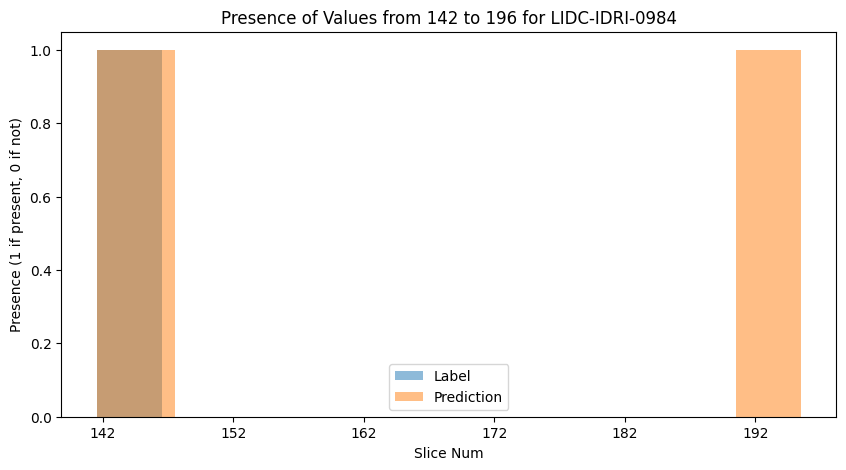

In [9]:
# Determines max y value to show on graph
y_min = indices[0]
y_max = indices[-1]

# Create an array of zeros for the range 0-200
pred_presence = [0] * (y_max-y_min)
label_presence = [0] * (y_max-y_min)

# Mark presence of each value in the list
for i, pred, label in zip(indices, preds_filtered, labels_filtered):
    if pred != []:
        pred_presence[i-y_max] = 1
    if label != []:
        label_presence[i-y_max] = 1

# Plot
plt.figure(figsize=(10, 5))
plt.bar(range(y_min, y_max), label_presence, width=1.0, alpha=.5, label='Label')
plt.bar(range(y_min, y_max), pred_presence, width=1.0, alpha=.5, label='Prediction')
plt.xlabel('Slice Num')
plt.ylabel('Presence (1 if present, 0 if not)')
plt.title(f'Presence of Values from {y_min} to {y_max} for {patient_id}')
plt.xticks(range(y_min, y_max, 10))
plt.legend()
plt.show()

In [10]:
# Extract noduels from indices
p_nods = help.get_nodules(indices, preds_filtered)
l_nods = help.get_nodules(indices, labels_filtered)

print(f"# of actual nodules: {len(l_nods)}")
print(f"# of predicted nodules: {len(p_nods)}")

prec, rec, f1 = help.get_metrics(p_nods, l_nods)
print(f"Precision: {prec}")
print(f"Recall: {rec}")
print(f"F1: {f1:.2f}")

# of actual nodules: 1
# of predicted nodules: 2
Precision: 0.5
Recall: 1.0
F1: 0.67
